<a href="https://colab.research.google.com/github/SruthiSuresh12/gwas-height-analysis/blob/main/GWAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROJECT: GWAS on Height with PRS
### Full GWAS workflow demonstrating:
- 1. Load SNP-trait association data
- 2. Filter significant SNPs
- 3. Enhanced Manhattan plot
- 4. Enhanced QQ plot
- 5. Save processed results



In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
from plinkio import plinkfile
import scipy.stats as stats

In [16]:
# -------------------------------
# Step 1: Load GWAS Catalog Associations
# -------------------------------
# Load the downloaded TSV for your trait
assoc_df = pd.read_csv(
    "gwas-association-downloaded_2025-09-13-OBA_VT0001253.tsv",
    sep='\t'
)
# Strip whitespace from column names
assoc_df.columns = assoc_df.columns.str.strip()

# Rename columns for standard workflow
assoc_df.rename(columns={
    'CHR_ID': 'Chrom',
    'CHR_POS': 'Pos',
    'SNP_ID_CURRENT': 'SNP',
    'P-VALUE': 'P-value',
    'OR or BETA': 'Beta'
}, inplace=True)

# Convert chromosome to string, strip spaces
assoc_df['Chrom'] = assoc_df['Chrom'].astype(str).str.strip()

# Remove rows with missing chromosome or P-value/Beta
assoc_df = assoc_df[assoc_df['Chrom'].notna()]
assoc_df['P-value'] = pd.to_numeric(assoc_df['P-value'], errors='coerce')
assoc_df['Beta'] = pd.to_numeric(assoc_df['Beta'], errors='coerce')
assoc_df = assoc_df.dropna(subset=['P-value', 'Beta', 'Pos'])

# Ensure position is numeric
assoc_df['Pos'] = pd.to_numeric(assoc_df['Pos'], errors='coerce')

# Compute -log10(P-value)
assoc_df['-log10P'] = -np.log10(assoc_df['P-value'])


/tmp/ipython-input-4182129597.py:5: DtypeWarning: Columns (11,13,26) have mixed types. Specify dtype option on import or set low_memory=False.
  assoc_df = pd.read_csv(
/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [18]:
# -------------------------------
# Step 2: Filter Significant SNPs
# -------------------------------
# Genome-wide significance threshold
sig_threshold = 5e-8

# Filter SNPs below the significance threshold
sig_snps = assoc_df[assoc_df['P-value'] < sig_threshold]
print(f"Number of genome-wide significant SNPs: {len(sig_snps)}")

Number of genome-wide significant SNPs: 32462


In [26]:
# -------------------------------
# Step 3: Chromosome Cleaning & Sorting for Manhattan Plot
# -------------------------------

# 1. Clean Chromosome column: convert floats like '1.0' -> '1', uppercase X/Y/MT, remove invalids
def clean_chrom(chrom):
    chrom = str(chrom).strip()  # ensure string
    if chrom.upper() in ['X','Y','MT','M']:
        return chrom.upper()
    try:
        # Convert numeric floats like '1.0' to integer string '1'
        return str(int(float(chrom)))
    except:
        return None  # invalid entry

assoc_df['Chrom'] = assoc_df['Chrom'].apply(clean_chrom)
assoc_df = assoc_df[assoc_df['Chrom'].notna()]  # remove invalid/missing

# 2. Define sort key for chromosomes
def chrom_sort_key(chrom):
    chrom = chrom.upper()
    if chrom.isdigit():
        return int(chrom)
    elif chrom == 'X':
        return 23
    elif chrom == 'Y':
        return 24
    elif chrom in ['MT','M']:
        return 25
    else:
        return 100  # any unusual chromosomes at the end

# 3. Sort dataframe by chromosome and position
assoc_df = assoc_df.sort_values(
    ['Chrom', 'Pos'],
    key=lambda x: x.map(lambda c: chrom_sort_key(str(c)))
).reset_index(drop=True)

# 4. Compute cumulative positions for Manhattan plot
chrom_sizes = assoc_df.groupby('Chrom')['Pos'].max()
chrom_offsets = {}
offset = 0
for chrom in sorted(chrom_sizes.index, key=chrom_sort_key):
    chrom_offsets[chrom] = offset
    offset += chrom_sizes[chrom]

assoc_df['cum_pos'] = assoc_df.apply(lambda row: row['Pos'] + chrom_offsets[row['Chrom']], axis=1)

# 5. Check unique chromosomes after cleaning
print("Unique chromosomes after cleaning:", sorted(assoc_df['Chrom'].unique(), key=chrom_sort_key))


Unique chromosomes after cleaning: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', 'X']


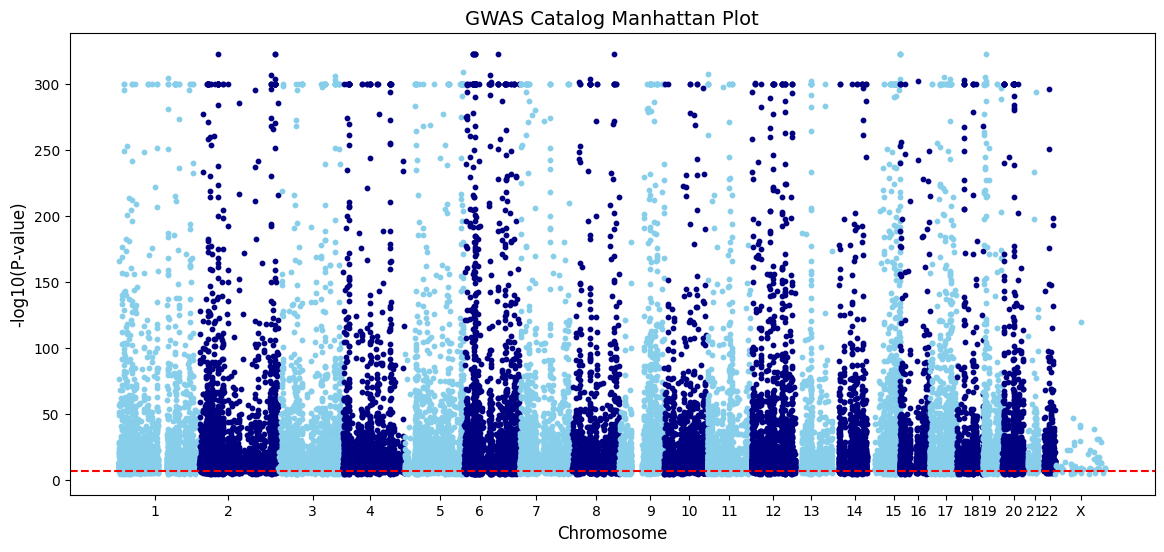

/tmp/ipython-input-2735916366.py:29: RuntimeWarning: divide by zero encountered in log10
  observed = -np.log10(np.sort(assoc_df['P-value']))


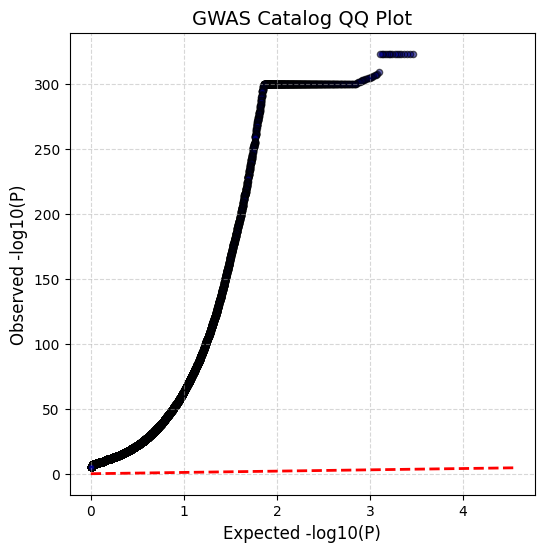

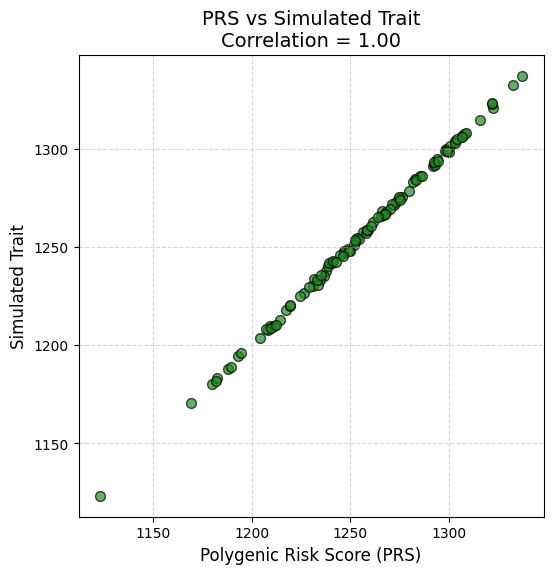

Processing complete. Files saved.


In [27]:
# -------------------------------
# Step 4: Enhanced Manhattan Plot
# -------------------------------
plt.figure(figsize=(14,6))
colors = ['skyblue', 'navy']
for i, chrom in enumerate(sorted(assoc_df['Chrom'].unique(), key=chrom_sort_key)):
    df = assoc_df[assoc_df['Chrom'] == chrom]
    plt.scatter(df['cum_pos'], df['-log10P'], c=colors[i % 2], s=10)

plt.xlabel("Chromosome", fontsize=12)
plt.ylabel("-log10(P-value)", fontsize=12)
plt.title("GWAS Catalog Manhattan Plot", fontsize=14)
plt.axhline(-np.log10(sig_threshold), color='red', linestyle='dashed', label='Genome-wide significance')

# Highlight top 5 SNPs
top_snps = assoc_df.nsmallest(5, 'P-value')
for _, row in top_snps.iterrows():
    plt.text(row['cum_pos'], row['-log10P'] + 0.3, row['SNP'], rotation=45, fontsize=8)

# Chromosome ticks at median positions
chrom_midpoints = assoc_df.groupby('Chrom')['cum_pos'].median()
plt.xticks(chrom_midpoints, chrom_midpoints.index)
plt.legend().remove()
plt.show()

# -------------------------------
# Step 5: Enhanced QQ Plot
# -------------------------------
observed = -np.log10(np.sort(assoc_df['P-value']))
expected = -np.log10(np.linspace(1/len(assoc_df), 1, len(assoc_df)))

plt.figure(figsize=(6,6))
plt.scatter(expected, observed, c='darkblue', s=20, alpha=0.6, edgecolor='k')
plt.plot([0, max(expected)], [0, max(expected)], color='red', linestyle='--', lw=2)
plt.xlabel("Expected -log10(P)", fontsize=12)
plt.ylabel("Observed -log10(P)", fontsize=12)
plt.title("GWAS Catalog QQ Plot", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# -------------------------------
# Step 6: Save Processed Results
# -------------------------------
assoc_df.to_csv("gwas_catalog_processed.tsv", index=False)
prs_df.to_csv("simulated_prs.csv", index=False)
print("Processing complete. Files saved.")